In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import pickle
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
from gensim.models import CoherenceModel
import pyLDAvis.gensim
from sklearn.cluster import MiniBatchKMeans
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [3]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            result.append(lemmatize_stemming(token))
    return result

In [4]:
def get_coherence(model):
    coherence_model_lda = CoherenceModel(model=model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

In [5]:
def concat_all_responses(prompt):
    series = train.response[train.prompt == prompt]
    response_cat = series.str.cat(sep=" ")
    return (prompt + response_cat)

In [6]:
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

In [7]:
def get_topic_vecs(preprocessed):
    lda_vecs = lda_model.get_document_topics(dictionary.doc2bow(preprocessed), minimum_probability=0.0)
    topic_vecs = [i[1] for i in lda_vecs]
    return topic_vecs

In [8]:
def get_top_topic(arr):
    top_topic = max(arr,key=lambda x:x[1])[0]
    return top_topic

<b>Read in and clean data

Concatenate train and val to generate topics.

In [9]:
col_names = ['col1','col2','col3','col4','col5','col6','col7','col8','col9','col10']

train = pd.read_csv("train.csv", header=None, names=col_names, low_memory=False)
val = pd.read_csv("valid.csv", header=None, names=col_names, low_memory=False)

In [10]:
train = pd.concat([train,val])

train = train[['col3','col4','col6']][1:]
train.index.names =['id']
train.drop_duplicates(inplace=True)
train.columns = ['prompt_sentiment','prompt','response']
train.prompt = train.prompt.str.replace('_comma_',',',regex=True)
train.response = train.response.str.replace('_comma_',',',regex=True)

<b> Concatenate prompts with all responses </b>

In [11]:
prompts = pd.DataFrame(train.prompt.drop_duplicates()).reset_index(drop=True)

In [12]:
prompts['concat'] = prompts.prompt.apply(concat_all_responses)

<b> Preprocess text data </b>

In [13]:
processed_docs = prompts.concat.map(preprocess)

<b> Create TD-IDF from corpus </b>

In [14]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [15]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [16]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [17]:
pickle.dump(dictionary, open('lda_dictionary.pickle','wb'))
pickle.dump(bow_corpus, open('lda_bow_corpus.pickle','wb'))

<b> Find optimal number of LDA topics

In [17]:
num_topics_range = range(5,85,5)

In [18]:
coherences = []
for i in num_topics_range:
    model = gensim.models.LdaMulticore(corpus_tfidf, 
                                       num_topics=i, 
                                       id2word=dictionary, 
                                       passes=5,
                                       workers=10)
    coherence = get_coherence(model)
    coherences.append(coherence)

In [145]:
pickleIt = False
if pickleIt == True:
    coherences_dict = dict(zip(num_topics_range, coherences))
    pickle.dump(coherences_dict, open('coherences_dict.pickle', 'wb'))

Plot coherence score against number of topics.

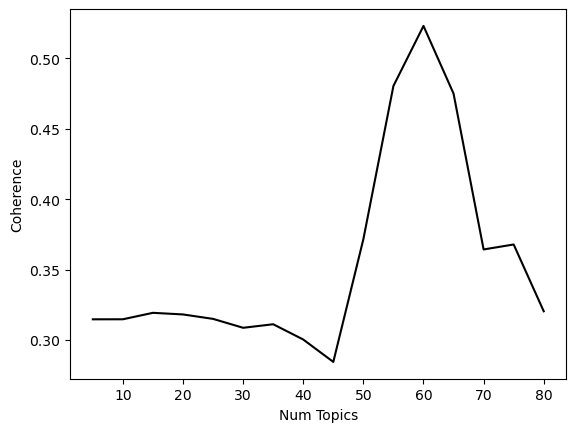

<Figure size 640x480 with 0 Axes>

In [99]:
plt.rcParams.update(plt.rcParamsDefault)

plt.plot(num_topics_range, coherences, color = 'black')
plt.xlabel("Num Topics",fontsize=10)
plt.ylabel("Coherence",fontsize=10)
plt.grid(False)
plt.show()
plt.savefig('fig_lda_coherence.png')

<b> Create topic model

In [18]:
lda_model = gensim.models.LdaMulticore(corpus_tfidf, 
                                       num_topics=60, 
                                       id2word=dictionary, 
                                       passes=5,
                                       workers=4)

In [19]:
pickleIt = True
if pickleIt == True:
    pickle.dump(lda_model, open('lda_model.pickle', 'wb'))

In [116]:
show = False
if show == True:
    for idx, topic in lda_model.print_topics(-1):
        print('Topic: {} Word: {}'.format(idx, topic))

<b> PyLDAvis Representation

In [23]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
54     0.325028 -0.009556       1        1  21.735706
9      0.263925  0.047117       2        1   7.920151
41     0.258411 -0.010320       3        1   6.834663
27     0.241124  0.014093       4        1   5.776106
36     0.255675 -0.006476       5        1   5.359496
42     0.197493 -0.077973       6        1   3.117094
55     0.168058  0.042698       7        1   2.841452
4      0.182157  0.063911       8        1   2.633153
1      0.183973 -0.045493       9        1   2.471201
12     0.185385  0.037821      10        1   2.461097
7      0.119137 -0.143303      11        1   2.354765
30     0.152642  0.030597      12        1   2.063412
17     0.168230 -0.009228      13        1   2.025840
58     0.166379 -0.026997      14        1   1.871850
34     0.127496  0.055405      15        1   1.833811
47     0.073177  0.150196      16        1   1.771978
16     0.127072 -0.077023      17        1   1.744998
8      0.139347  0.002944      18        1   1.742968
39     0.076702  0.089219      19        1   1.544771
18     0.116583  0.001706      20        1   1.233629
45     0.084400  0.073785      21        1   1.209498
23    -0.002463 -0.098836      22        1   1.170040
35     0.045290 -0.112718      23        1   1.165832
28    -0.005208  0.044050      24        1   1.079579
5      0.003289 -0.153494      25        1   0.997558
32    -0.005000  0.118150      26        1   0.899558
25    -0.041923 -0.023622      27        1   0.853662
29     0.059654  0.023312      28        1   0.843099
6      0.072316 -0.037566      29        1   0.785164
3      0.044857 -0.059949      30        1   0.714665
56    -0.020569 -0.001981      31        1   0.685976
11    -0.054421 -0.056399      32        1   0.583889
51    -0.015863  0.046695      33        1   0.546485
44    -0.033773 -0.002500      34        1   0.541573
52    -0.005709 -0.003605      35        1   0.541108
48    -0.094305  0.052795      36        1   0.534970
31    -0.051137  0.003293      37        1   0.514232
20    -0.070242 -0.005366      38        1   0.496056
19    -0.069519  0.019965      39        1   0.485116
10    -0.038754  0.080003      40        1   0.457101
21    -0.052836  0.012901      41        1   0.442450
43    -0.055691 -0.036716      42        1   0.440167
49    -0.149546  0.005087      43        1   0.413483
50    -0.121292  0.004321      44        1   0.380713
40    -0.161157 -0.047981      45        1   0.331671
46    -0.148762 -0.003098      46        1   0.308108
26    -0.172910  0.011420      47        1   0.290756
0     -0.180557 -0.004674      48        1   0.283565
33    -0.179020 -0.002197      49        1   0.278349
59    -0.169128 -0.012915      50        1   0.262448
37    -0.185075 -0.014932      51        1   0.252241
57    -0.182142  0.001453      52        1   0.251530
13    -0.196739  0.011501      53        1   0.246937
24    -0.186432 -0.000459      54        1   0.245423
53    -0.190133  0.006003      55        1   0.234212
22    -0.186520  0.013360      56        1   0.205192
15    -0.200884  0.004480      57        1   0.193697
14    -0.203119  0.000516      58        1   0.175104
38    -0.202760  0.009336      59        1   0.161146
2     -0.204211  0.007245      60        1   0.159504, topic_info=         Term         Freq        Total Category  logprob  loglift
524       dog  2486.000000  2486.000000  Default  30.0000  30.0000
74        job  2660.000000  2660.000000  Default  29.0000  29.0000
866   brother  1512.000000  1512.000000  Default  28.0000  28.0000
1215     test   911.000000   911.000000  Default  27.0000  27.0000
266       win  1418.000000  1418.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
36      didnt     1.600589   379.584381  Topic60  -6.5749   0.9722
443     order     1.562120   493.980194  Topic60  -6.5992   0.6844
914   

<b> Get topic distribution vectors for responses

In [24]:
responses = pd.DataFrame(train)
responses['response_preprocess'] = responses.response.map(preprocess) 
responses['response_topic_dist'] = responses.response_preprocess.apply(lambda x: lda_model[dictionary.doc2bow(x)])
responses['response_top_topic'] = responses.response_topic_dist.map(get_top_topic)
responses['response_topic_vec'] = responses.response_preprocess.map(get_topic_vecs)

In [45]:
to_csv = False
if to_csv == True:
    responses.to_csv('annotated_train.csv',index=False)

In [25]:
X = np.array(responses.response_topic_vec.values.tolist())
X.shape

(88503, 60)

<b> PCA

In [26]:
pca = PCA(n_components=40)
principleComponents = pca.fit_transform(X)
PCA_components = pd.DataFrame(principleComponents)

Scree plot

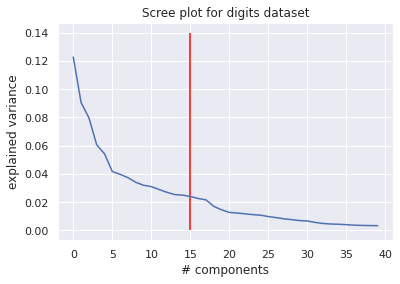

In [27]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('# components')
plt.ylabel('explained variance');
plt.vlines(15,0,.14,color='red');
plt.title('Scree plot for digits dataset');

Explained variance plot

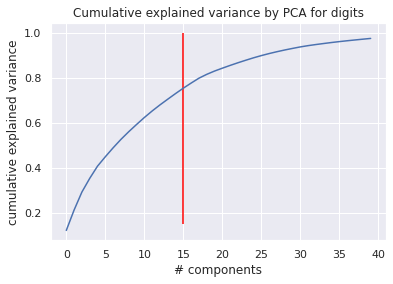

In [28]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('# components')
plt.ylabel('cumulative explained variance');
plt.vlines(15,0.15,1,color='red');
plt.title('Cumulative explained variance by PCA for digits');

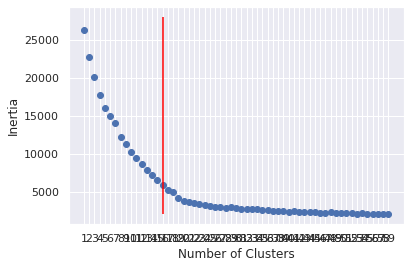

In [29]:
ks = range(1,60)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:18])
    inertias.append(model.inertia_)
    
plt.scatter(ks,inertias)
plt.vlines(16,2000,28000,color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

<b> T-SNE

In [134]:
tsne = False
if tsne == True:
    tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
    tsne_lda = tsne_model.fit_transform(X);

In [129]:
pickleIt = False
if pickleIt == True:
    pickle.dump(tsne_lda,open('tsne_lda.pickle','wb'))

In [30]:
loadPickle = True
if loadPickle == True:
    tsne_lda = pickle.load(open('tsne_lda.pickle','rb'))

In [36]:
(tsne_lda[:,0])

array([ 35.648094 ,  -0.1778722,  34.729725 , ...,  -8.287126 ,
        23.436308 , -16.274534 ], dtype=float32)

In [38]:
colors = []
for i in range(60):
    c = np.random.rand(3,)
    colors.append(c)

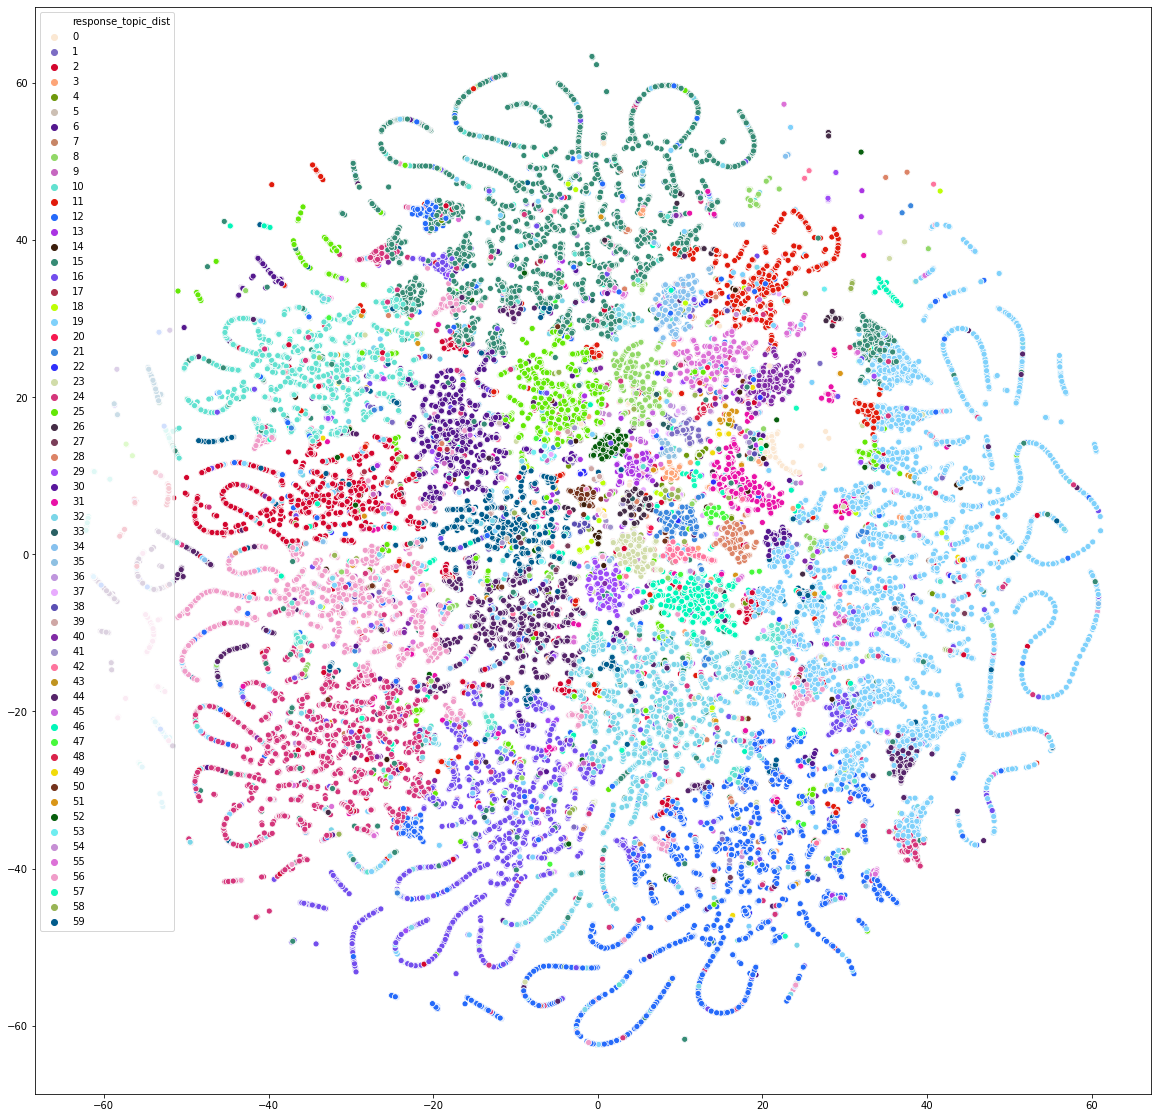

In [232]:
palette = sns.diverging_palette(250, 15, s=75, l=40,n=60)
plt.figure(figsize=(20,20))
sns.scatterplot(x=tsne_lda[:,0], y=tsne_lda[:,1],hue=top_topics,palette=colors);

<b> Plotting the confusion matrix

In [52]:
true = pickle.load(open('true_vals_working_BERT.pickle','rb'))
pred = pickle.load(open('predictions_working_BERT.pickle','rb'))

In [53]:
from sklearn.metrics import f1_score
def f1_score_func(pred, labels):
    preds_flat = np.argmax(pred, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [54]:
f1_score_func(pred,true)

0.5655915416087888

In [55]:
preds_flat = np.argmax(pred, axis=1).flatten()

In [56]:
df = pd.DataFrame()
df['pred'] = pd.Series(preds_flat)
df['true'] = pd.Series(true)

In [57]:
train = pd.read_csv("train.csv", header=None, names=col_names, low_memory=False)
train = train[['col3','col4']][1:]
train.index.names =['id']
train.columns = ['sentiment','text']

In [58]:
possible_labels = train.sentiment.unique()

In [59]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [60]:
rev_label_dict = {v: k for k, v in label_dict.items()}

In [61]:
df = df.replace(rev_label_dict)

In [62]:
conf_mat = confusion_matrix(df.true, df.pred)

In [63]:
labels = list(label_dict.keys())

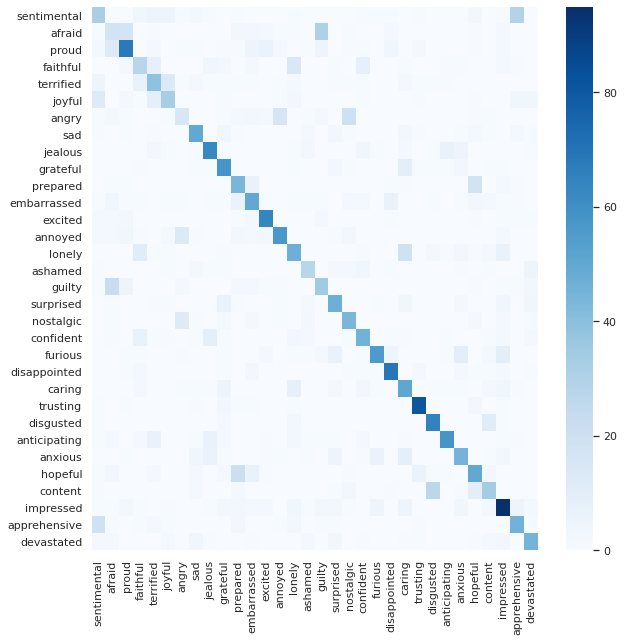

In [76]:
plt.figure(figsize=(10,10));
sns.set(font_scale=1);
sns.heatmap(conf_mat,xticklabels=labels,yticklabels=labels,cmap="Blues");
plt.savefig('fig_conf_mat.png')